## Importing Required Libraries

In [2]:
import os
Root="/content/drive/MyDrive/Colab Notebooks"
os.chdir(Root)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)
from matplotlib import style
style.use('fivethirtyeight')

## Assigning Path for Dataset

In [4]:
data_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset"
train_path = '/content/drive/MyDrive/Colab Notebooks/Train'
test_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 32
IMG_WIDTH = 32
channels = 3

## Finding Total Classes

In [5]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [6]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Visualizing The Dataset

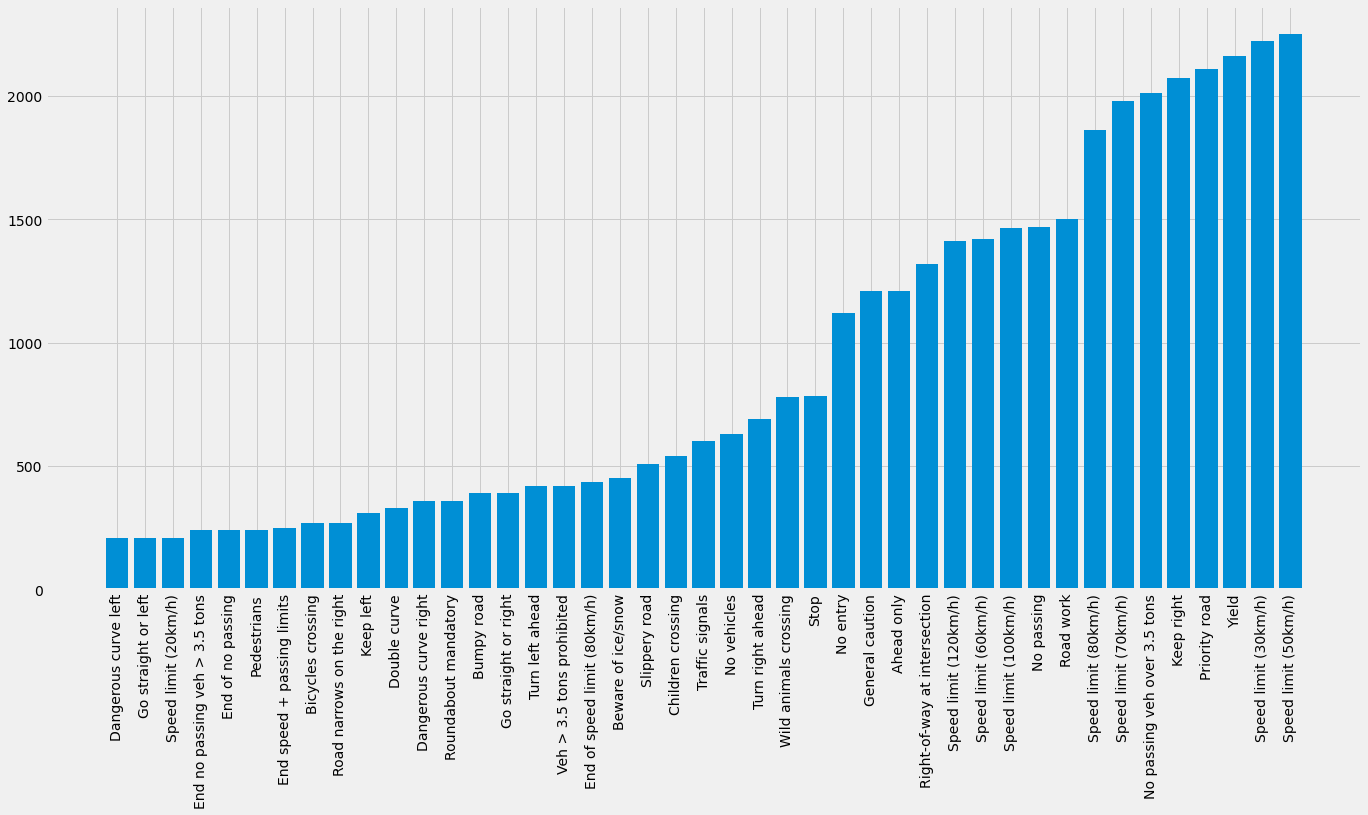

In [7]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

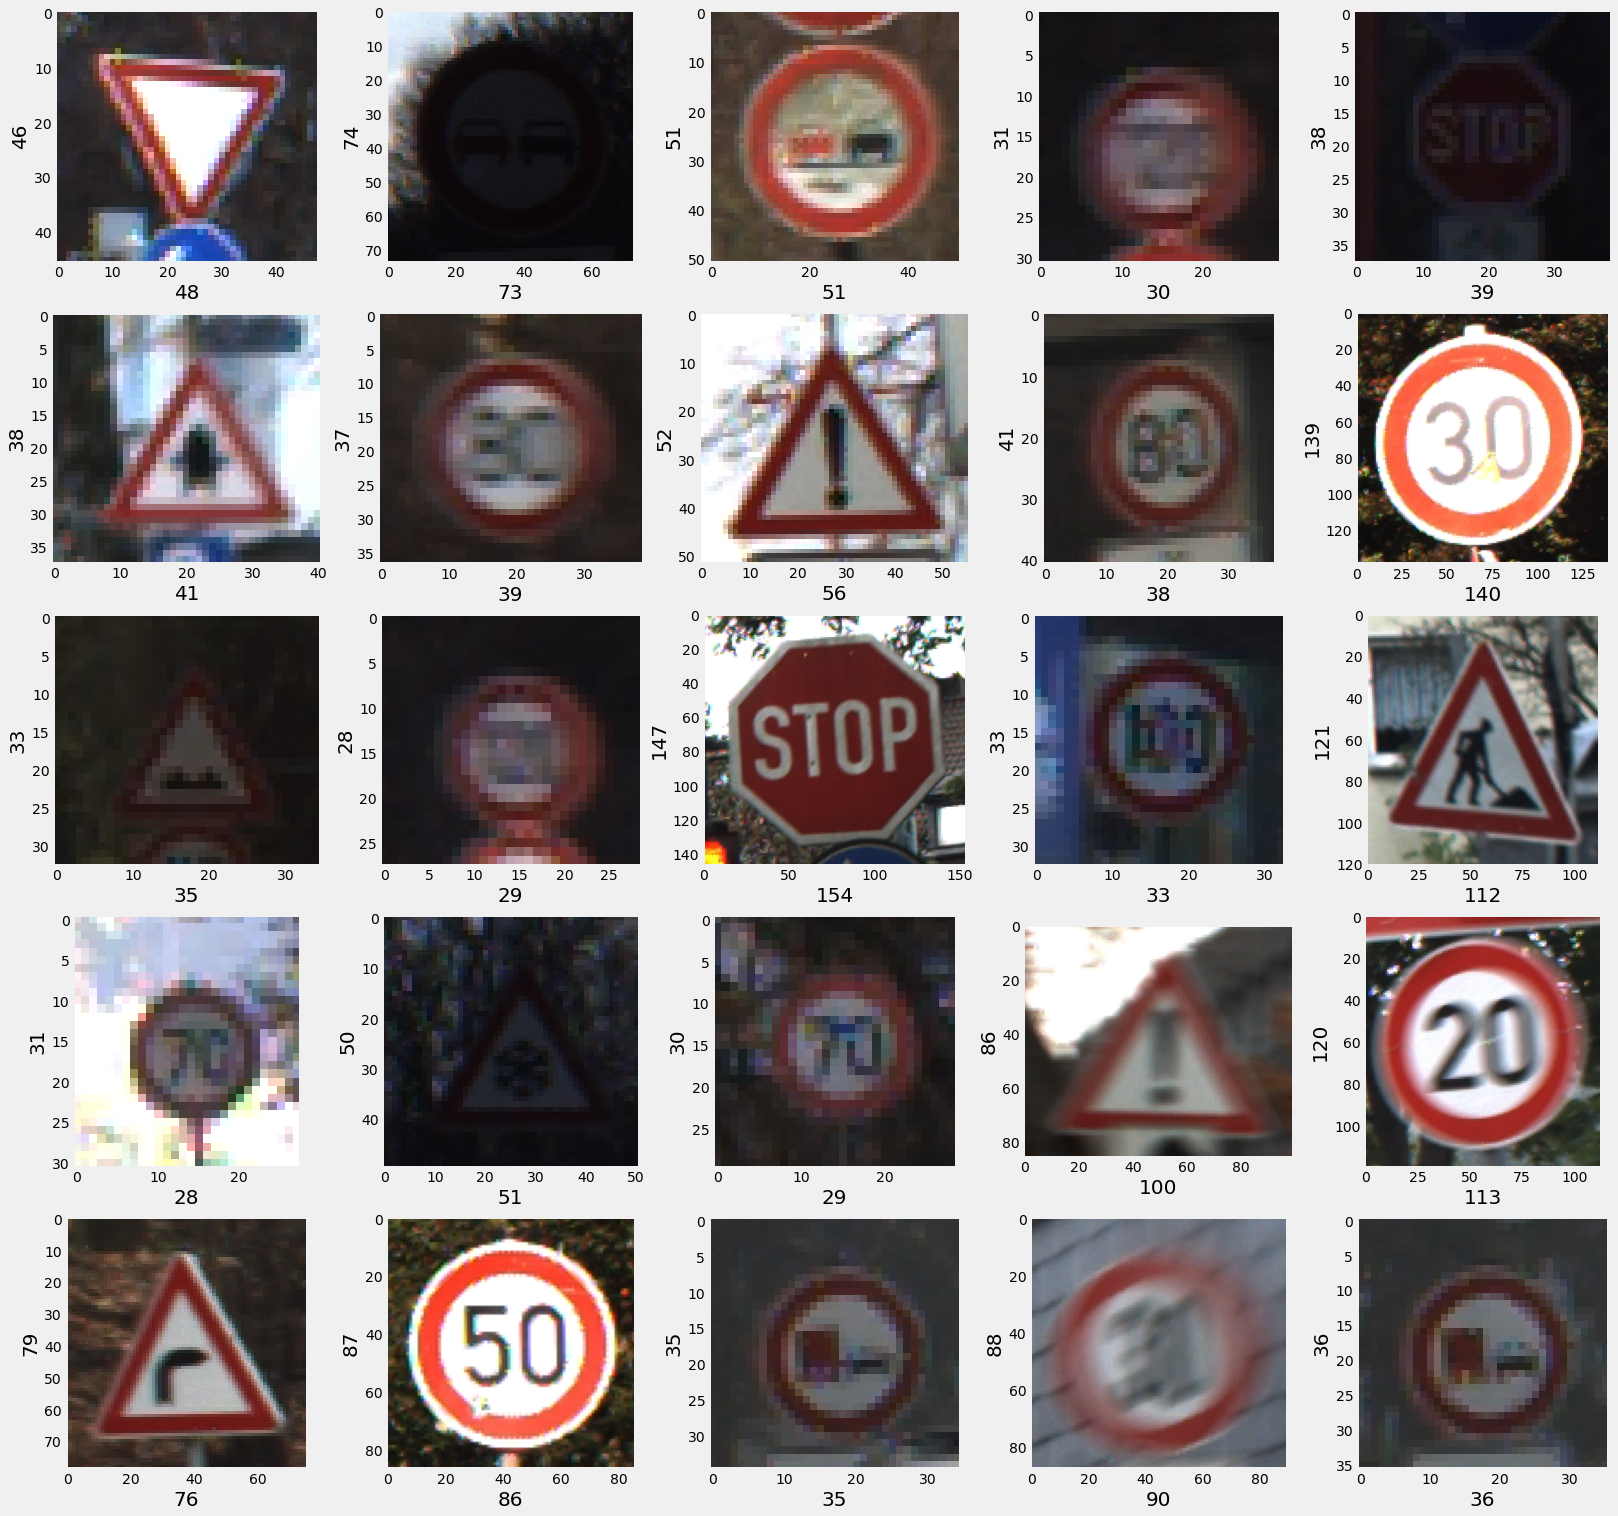

In [8]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

## Collecting the Training Data

In [9]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path =  '/content/drive/MyDrive/Colab Notebooks/Train/' + str(i)
    #path=Root+'Train' +str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39321, 32, 32, 3) (39321,)


## Shuffling the training data

In [10]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set

In [11]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27524, 32, 32, 3)
X_valid.shape (11797, 32, 32, 3)
y_train.shape (27524,)
y_valid.shape (11797,)


## One hot encoding the labels

In [12]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, NUM_CATEGORIES)
y_val =to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27524, 43)
(11797, 43)


# **Models**

## **1] LeNet-5 Model**

In [13]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,1)))
model.add(keras.layers.AveragePooling2D())

model.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(keras.layers.AveragePooling2D())

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(units=120, activation='relu'))

model.add(keras.layers.Dense(units=84, activation='relu'))

model.add(keras.layers.Dense(units=43, activation = 'softmax'))

In [26]:
lr = 0.004
epochs =15

opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#### **Augmenting the data and training the model**




In [27]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

history = model.fit(aug.flow(X_train, y_train, batch_size=64), epochs=15, validation_data=(X_val, y_val))

Epoch 1/15
431/431 [==============================] - 15s 34ms/step - loss: 2.2291 - accuracy: 0.3462 - val_loss: 1.1861 - val_accuracy: 0.6096
Epoch 2/15
431/431 [==============================] - 14s 33ms/step - loss: 1.2860 - accuracy: 0.5890 - val_loss: 0.7536 - val_accuracy: 0.7458
Epoch 3/15
431/431 [==============================] - 14s 32ms/step - loss: 0.9384 - accuracy: 0.6950 - val_loss: 0.5322 - val_accuracy: 0.8198
Epoch 4/15
431/431 [==============================] - 14s 32ms/step - loss: 0.7291 - accuracy: 0.7623 - val_loss: 0.3564 - val_accuracy: 0.8907
Epoch 5/15
431/431 [==============================] - 14s 33ms/step - loss: 0.5919 - accuracy: 0.8076 - val_loss: 0.3099 - val_accuracy: 0.8983
Epoch 6/15
431/431 [==============================] - 14s 33ms/step - loss: 0.5209 - accuracy: 0.8339 - val_loss: 0.2594 - val_accuracy: 0.9127
Epoch 7/15
431/431 [==============================] - 14s 32ms/step - loss: 0.4626 - accuracy: 0.8520 - val_loss: 0.2061 - val_accuracy:

#### **Loading the test data and running the predictions**

In [20]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

In [28]:
pred = np.argmax(model.predict(X_test), axis = 1)

#Accuracy with the test data
print('Test Data accuracy for LeNeT-5 Model: ',accuracy_score(labels, pred)*100)

Test Data accuracy for LeNeT-5 Model:  86.88044338875692


#### **Classification report**

In [29]:
from sklearn.metrics import classification_report
print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.75      0.35      0.48        60
           1       0.77      0.93      0.84       720
           2       0.84      0.88      0.86       750
           3       0.86      0.77      0.81       450
           4       0.95      0.82      0.88       660
           5       0.78      0.76      0.77       630
           6       0.89      0.57      0.70       150
           7       0.88      0.77      0.82       450
           8       0.79      0.91      0.84       450
           9       0.95      0.96      0.96       480
          10       0.97      0.97      0.97       660
          11       0.95      0.82      0.88       420
          12       0.98      0.97      0.97       690
          13       0.98      1.00      0.99       720
          14       0.94      1.00      0.97       270
          15       0.84      1.00      0.91       210
          16       0.99      0.99      0.99       150
          17       1.00    

#### **Evaluating the model**

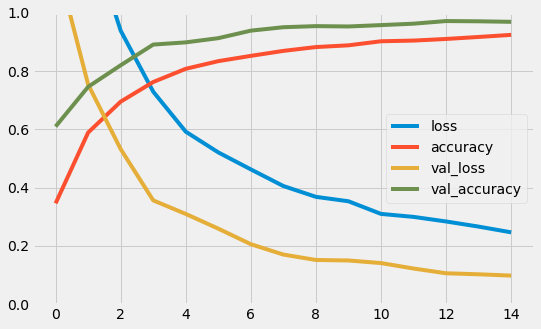

In [30]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

#### **Prediction on Test Data**

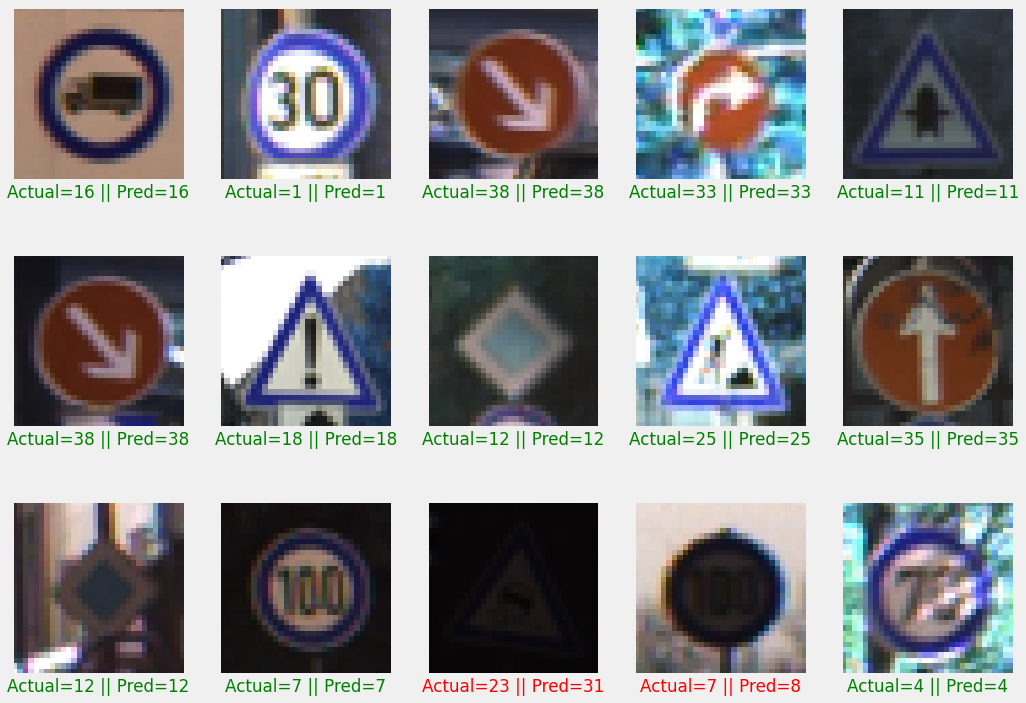

In [44]:
plt.figure(figsize = (16, 12))

start_index = 0
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

### **2]VGG16 model**

In [15]:
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D

vgg_model = VGG16(weights= 'imagenet', include_top=False, input_shape= (32,32,3))

In [16]:
model1=keras.Sequential()
for layer in vgg_model.layers:
    model1.add(layer)
#for layer in model1.layers:
 #   layer.trainable=False
model1.add(Flatten())
model1.add(Dropout(0.4))
model1.add(Dense(256,activation='relu'))
model1.add(Dense(43,activation='softmax'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0         
                                                                 
 block3_conv1 (Conv2D)       (None, 8, 8, 256)        

In [17]:
lr = 0.001
epochs = 15
opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
from keras.callbacks import EarlyStopping,ModelCheckpoint

stop = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

checkpoint= ModelCheckpoint(
    filepath='./',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [19]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")
history =  model1.fit(aug.flow(X_train, y_train, batch_size =64),validation_data = (X_val, y_val), epochs = 15,verbose = 1, callbacks = [stop, checkpoint])

Epoch 1/15
431/431 [==============================] - 35s 71ms/step - loss: 2.7055 - accuracy: 0.1975 - val_loss: 1.7683 - val_accuracy: 0.3742
Epoch 2/15
431/431 [==============================] - 26s 60ms/step - loss: 1.4107 - accuracy: 0.5088 - val_loss: 0.8636 - val_accuracy: 0.6478
Epoch 3/15
431/431 [==============================] - 26s 61ms/step - loss: 0.8183 - accuracy: 0.7159 - val_loss: 0.4376 - val_accuracy: 0.8403
Epoch 4/15
431/431 [==============================] - 25s 58ms/step - loss: 0.4268 - accuracy: 0.8569 - val_loss: 0.3696 - val_accuracy: 0.9085
Epoch 5/15
431/431 [==============================] - 23s 53ms/step - loss: 0.3566 - accuracy: 0.8891 - val_loss: 0.1460 - val_accuracy: 0.9545
Epoch 6/15
431/431 [==============================] - 23s 54ms/step - loss: 0.1853 - accuracy: 0.9383 - val_loss: 0.0977 - val_accuracy: 0.9666
Epoch 7/15
431/431 [==============================] - 23s 53ms/step - loss: 0.1462 - accuracy: 0.9551 - val_loss: 0.0913 - val_accuracy:

## Evaluating the model

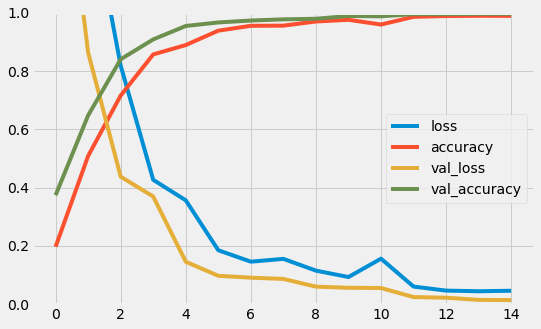

In [21]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

#### Loading the test data and running the predictions

In [22]:
pred1 = np.argmax(model1.predict(X_test), axis = 1)
#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred1)*100)

Test Data accuracy:  96.84877276326208


#### **VGG16 Classification report**





In [23]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred1))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       0.94      1.00      0.97       720
           2       0.97      1.00      0.98       750
           3       1.00      0.95      0.97       450
           4       1.00      0.98      0.99       660
           5       0.96      0.97      0.97       630
           6       1.00      0.89      0.94       150
           7       1.00      0.98      0.99       450
           8       0.98      0.97      0.98       450
           9       0.98      1.00      0.99       480
          10       1.00      1.00      1.00       660
          11       1.00      1.00      1.00       420
          12       0.99      0.99      0.99       690
          13       1.00      0.99      1.00       720
          14       0.93      1.00      0.97       270
          15       1.00      0.99      0.99       210
          16       1.00      1.00      1.00       150
          17       0.97    

## Predictions on Test Data

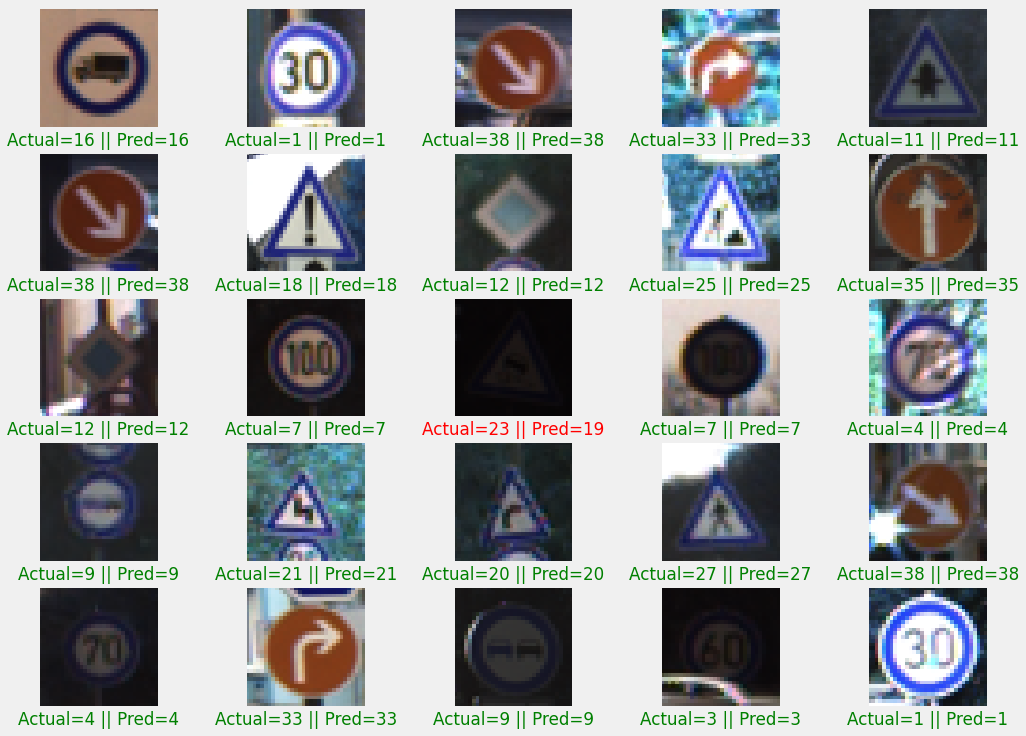

In [40]:
plt.figure(figsize = (16, 12))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred1[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()